In [2]:
import sklearn.tree
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.grid_search import GridSearchCV
from sklearn import cross_validation, metrics
from timeit import default_timer as timer
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

SECONDS_PER_CHAOS = 150

/home/benjamin/venv/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/benjamin/venv/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
features_pd = pd.read_csv('ring_features_1c.csv.bz2', compression='bz2')
features_pd.rename(columns={'Price':'price'}, inplace=True)
# Remove 17k chaos items from the dataset because manual inspection showed that they're worthless
# and people probably just set such a high price because they used their public tab as storage space
# and didn't want trade requests for the item.
features_pd = features_pd.loc[features_pd['price'] < 17000]

prices_pd = features_pd['price']
targets_pd = prices_pd.apply(lambda x: 1 if x > 0 else 0)
full_pd = features_pd.copy()
full_pd['valuable'] = targets_pd
full_pd['price'] = prices_pd

features_pd = full_pd[[x for x in full_pd.columns if x not in ['valuable', 'price', 'Unnamed: 0']]]

features = features_pd.as_matrix()[:,1:]
targets = targets_pd.as_matrix()
prices = prices_pd.apply(lambda x: min(x, 100)).as_matrix()
error_cost = (1-targets) + 2*prices
#error_cost /= error_cost.max()
print(features.shape, targets.shape)

print("Max Price:", prices.max())
print("Average Price:", prices.mean())

num_total = full_pd.shape[0]
num_valuable = full_pd['valuable'].sum()
num_worthless = num_total - num_valuable
print("Num valuable: {} ({}%)".format(num_valuable, (num_valuable / num_total) * 100))
print("Num worthless: {} ({}%)".format(num_worthless, (num_worthless / num_total) * 100))

(254419, 37) (254419,)
Max Price: 100
Average Price: 4.11922458621
Num valuable: 129303 (50.82285521128532%)
Num worthless: 125116 (49.17714478871468%)


In [4]:
tmask = np.random.choice([False,True], len(targets), p=[0.25, 0.75])
vmask = np.invert(tmask)
train_X = features[tmask]
train_Y = targets[tmask]
test_X = features[vmask]
test_Y = targets[vmask]

print("Training set: {} items, {:.1%} valuable".format(train_X.shape[0], sum(train_Y) / train_Y.shape[0]))
print("Validation set: {} items, {:.1%} valuable".format(test_X.shape[0], sum(test_Y) / test_Y.shape[0]))

target = 'valuable'
predictors = [x for x in full_pd.columns if x not in [target, 'Unnamed: 0', 'price']]


Training set: 191063 items, 50.8% valuable
Validation set: 63356 items, 51.0% valuable


In [5]:
cv_params = {'max_depth': [7,9,11]}
ind_params = {'learning_rate': 0.1, 'n_estimators': 100, 'max_depth':9, 'min_child_weight':6, 'gamma':0.15,
              'seed':41083, 'subsample': 0.8, 'colsample_bytree':0.9, 'objective':'binary:logistic', 
              'scale_pos_weight':1}
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), param_grid=cv_params, cv=5, n_jobs=4, iid=False, verbose=1)
start = timer()
optimized_GBM.fit(train_X, train_Y)
deltaTime = timer() - start
s = deltaTime % 60           
m = (deltaTime // 60) % 60  
h = deltaTime // 3600      
print("Training done after {}h {}m {}s".format(h,m,s))

Training done after 0.0h 21.0m 29.580863718991168s


In [6]:
optimized_GBM.grid_scores_, optimized_GBM.best_params_, optimized_GBM.best_score_

([mean: 0.66074, std: 0.00135, params: {'max_depth': 7},
  mean: 0.66142, std: 0.00155, params: {'max_depth': 9},
  mean: 0.66072, std: 0.00112, params: {'max_depth': 11}],
 {'max_depth': 9},
 0.6614153398821438)


Model Report
Accuracy : 0.6938
AUC Score (Train): 0.761245


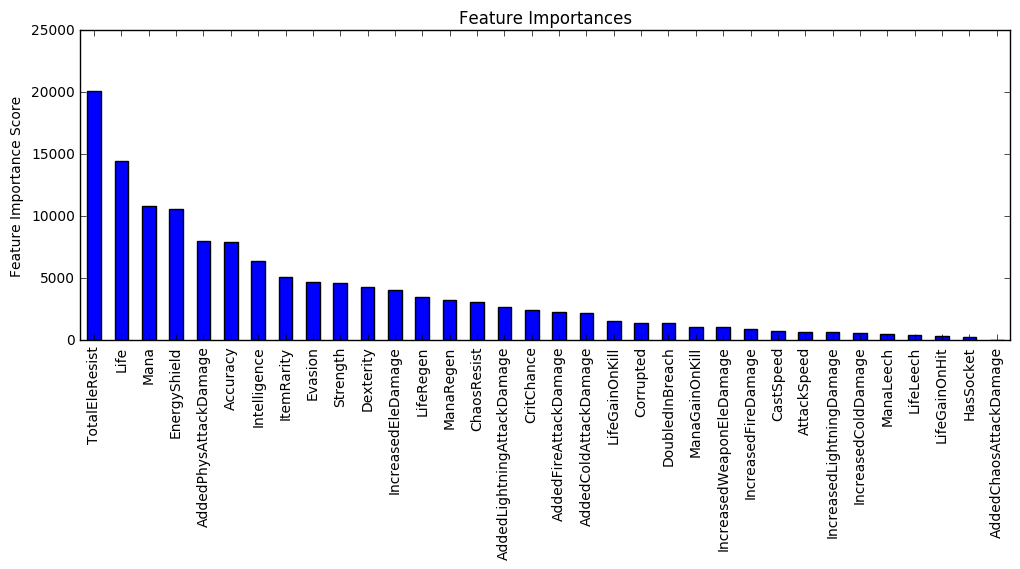

In [19]:
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    #xgb.plot_tree()
    
#ind_params = {'learning_rate': 0.1, 'n_estimators': 100, 'max_depth':9, 'min_child_weight':6, 'gamma':0.15,
#              'seed':41083, 'subsample': 0.8, 'colsample_bytree':0.8, 'objective': 'binary:logistic', 
#              'scale_pos_weight':1}

#dtrain = full_pd[tmask]
params = {**ind_params, **optimized_GBM.best_params_, 'learning_rate': 0.01, 'n_estimators':1000 }
#params = {**ind_params}#, 'objective':objective_playtime}
model = xgb.XGBClassifier(**params)
modelfit(model, dtrain, predictors, useTrainCV=True)

In [17]:
def duplicate_false_negatives_xgb(threshold):
    global dtrain

    num_fn = 0
    num_tp = 0
    false_negatives = []
    predictions_train = model.predict(dtrain[predictors])
    for i, (y, pred, price) in enumerate(zip(dtrain['valuable'], predictions_train, dtrain['price'])):
        if y == 1 and pred == 0 and price >= threshold:
            num_fn += 1
            false_negatives.append(dtrain.iloc[i])
        elif y == 1 and pred == 1 and price >= threshold:
            num_tp += 1
        
    dtrain = dtrain.append(false_negatives)
    return num_fn, num_tp


Model Report
Accuracy : 0.6906
AUC Score (Train): 0.759246
False negatives: 2089 (14.1%)

Model Report
Accuracy : 0.6844
AUC Score (Train): 0.753943
False negatives: 708 (8.1%)

Model Report
Accuracy : 0.6838
AUC Score (Train): 0.753710
False negatives: 737 (11.4%)

Model Report
Accuracy : 0.6847
AUC Score (Train): 0.754025
False negatives: 920 (16.9%)

Model Report
Accuracy : 0.6856
AUC Score (Train): 0.754898
False negatives: 925 (17.2%)

Model Report
Accuracy : 0.6864
AUC Score (Train): 0.754455
False negatives: 842 (13.2%)

Model Report
Accuracy : 0.6896
AUC Score (Train): 0.757983
False negatives: 612 (8.2%)

Model Report
Accuracy : 0.6904
AUC Score (Train): 0.758076
False negatives: 112 (1.3%)
Valuable Items Wasted: 44236 (34.2%)
Worthless Items Kept: 36378 (29.1%)
Currency wasted per hour of saved sort time: 148.0 chaos

Items wasted by currency:
    1 chaos:  25680 (46.3%)
    2 chaos:   5737 (36.3%)
    3 chaos:   3166 (33.1%)
    4 chaos:   1382 (28.2%)
    5 chaos:   5096 (

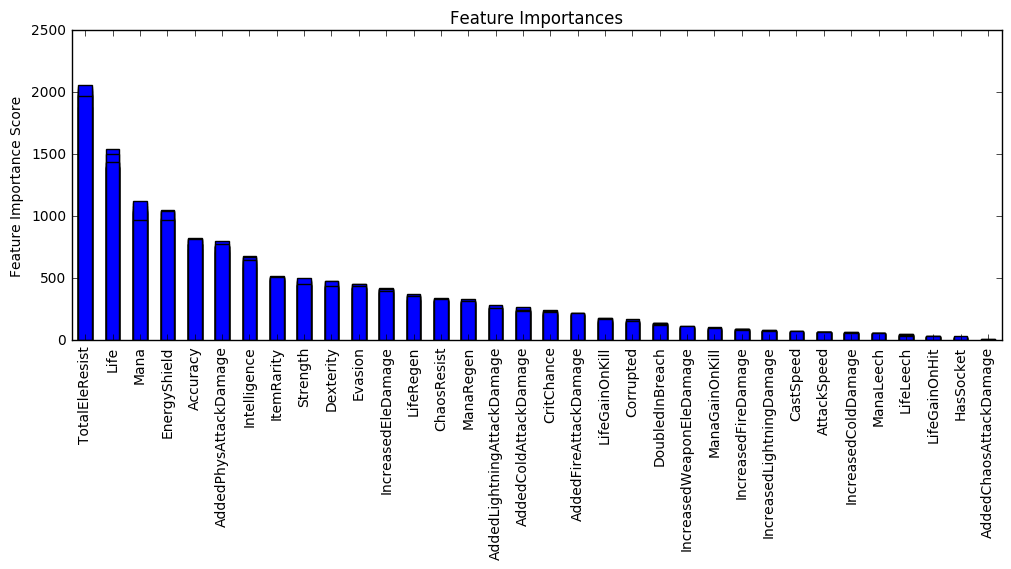

In [18]:
# Refine model by duplicating all valuable false negatives until they are properly detected
for t in [10,20,30,40,50,50,50,50,50,50]:
    modelfit(model, dtrain, predictors)
    num_fn, num_total = duplicate_false_negatives_xgb(t)
    print("False negatives: {} ({:.1f}%)".format(num_fn, (num_fn / num_total) * 100))
    if num_fn / num_total < 0.02:
        break

evaluate_predictions(model.predict(full_pd[predictors]), full_pd['price'].apply(lambda x: x > 0), full_pd['price'])

In [20]:
predictions = model.predict(full_pd[predictors])
evaluate_predictions(predictions, full_pd['price'].apply(lambda x: x > 0), full_pd['price'])


#ones = np.asarray([1]*predictions.shape[0])
#precision, recall, _ = metrics.precision_recall_curve(test_Y, predictions)
#average_precision = metrics.average_precision_score(test_Y, predictions)
#precision_micro, recall_micro, _ = metrics.precision_recall_curve(test_Y.ravel(), predictions.ravel())
#average_precision_micro = metrics.average_precision_score(test_Y.ravel(), predictions.ravel(), average='micro')


#evaluate_predictions(predicted, actual, prices[vmask])
#print("Precision:", precision)
#print("Recall:", recall)

#plt.clf()
#plt.plot(recall, precision, lw=2, color='navy', label='Precision-Recall curve')
#plt.xlabel('Recall')
#plt.ylabel('Precision')
#plt.ylim([0.0, 1.05])
#plt.xlim([0.0, 1.0])
#plt.title('AUC={:0.2f}'.format(average_precision))
#plt.legend(loc='lower left')
#plt.show()

Valuable Items Wasted: 44014 (34.0%)
Worthless Items Kept: 35904 (28.7%)
Currency wasted per hour of saved sort time: 142.0 chaos

Items wasted by currency:
    1 chaos:  25559 (46.1%)
    2 chaos:   5705 (36.1%)
    3 chaos:   3149 (32.9%)
    4 chaos:   1375 (28.1%)
    5 chaos:   5088 (31.5%)
    6 chaos:    297 (20.3%)
    7 chaos:    219 (18.0%)
    8 chaos:    255 (15.8%)
    9 chaos:    116 (19.0%)
   10 chaos:   1640 (25.4%)
   11 chaos:      8 (5.0%)
   12 chaos:     42 (7.5%)
   13 chaos:     22 (10.0%)
   14 chaos:     10 (5.0%)
   15 chaos:    188 (8.0%)
   16 chaos:      6 (7.0%)
   17 chaos:     51 (20.8%)
   18 chaos:      4 (3.0%)
   19 chaos:     14 (14.0%)
   20 chaos:    101 (4.9%)
   21 chaos:      2 (5.1%)
   22 chaos:      4 (3.1%)
   23 chaos:      1 (3.3%)
   24 chaos:      2 (3.0%)
   25 chaos:     49 (4.9%)
   28 chaos:      3 (6.0%)
   29 chaos:      2 (5.1%)
   30 chaos:     19 (1.7%)
   32 chaos:      1 (4.0%)
   34 chaos:      2 (10.0%)
   35 chaos:      6

In [21]:
model._Booster.save_model('./rings.xgb')

In [11]:
def format_time(seconds):
    s = seconds%60
    m = (seconds//60)%60
    h = seconds//3600
    return "{}h {}m {}s".format(h,m,s)

def evaluate_predictions(predictions, actual_y, prices):
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    invalid_stuff = 0
    playtime_saved = 0
    playtime_wasted = 0
    wasted_by_currency = Counter()
    count_by_currency = Counter()
    for actual, predicted, p in zip(actual_y, predictions, prices):
        count_by_currency[p] += 1
        if actual == 1 and predicted == 1:
            true_positives += 1
            playtime_saved += 10
        elif actual == 0 and predicted == 0:
            true_negatives += 1
            # This doesn't save time, player still has to price-check
        elif actual == 0 and predicted == 1:
            false_positives += 1
            # This doesn't waste time, player would do this without the tool anyway
        elif actual == 1 and predicted == 0:
            false_negatives += 1
            playtime_wasted += p * 150
            wasted_by_currency[p] += 1
        else:
            invalid_stuff += 1

    valuable_percent = sum(actual_y) / len(actual_y)
    playtime_saved = playtime_saved / valuable_percent * 0.05
    playtime_wasted = playtime_wasted * valuable_percent * 0.05

    manual_sort_time = (len(actual_y) - sum(actual_y)) * 10 + sum(test_Y) * 30
    assisted_sort_time = false_positives * 10 + (sum(predictions) - false_positives) * 30

    print("Valuable Items Wasted: {} ({:.1f}%)".format(false_negatives, 100*(false_negatives / (false_negatives + true_positives))))
    print("Worthless Items Kept: {} ({:.1f}%)".format(false_positives, 100*(false_positives / (false_positives + true_negatives))))

    #print("Playtime Saved at 95% Junk:", format_time(playtime_saved))
    #print("Playtime Wasted at 95% Junk:", format_time(playtime_wasted))

    #print("Manual Sort Time:", format_time(manual_sort_time / valuable_percent * 0.05))
    #print("Assisted Sort Time:", format_time(assisted_sort_time / valuable_percent * 0.05))
    #print("Currency Wasted:", playtime_wasted / 300, "Chaos")
    
    cph = playtime_wasted / playtime_saved * 3600 / SECONDS_PER_CHAOS
    print("Currency wasted per hour of saved sort time: {:.1f} chaos".format(cph))
    print()
    print("Items wasted by currency:")
    for k,v in sorted(wasted_by_currency.items()):
        percent = v / count_by_currency[k]
        print("{:5} chaos: {:6} ({:.1%})".format(k,v,percent))


# Neural Network 

In [329]:
from sklearn.model_selection import train_test_split
features_pd = full_pd[[x for x in full_pd.columns if x not in ['valuable', 'Unnamed: 0']]]
targets_pd = full_pd['valuable']
X_train, X_test, y_train, y_test = train_test_split(features_pd, targets_pd)
p_train = X_train['price']
p_test = X_test['price']
X_train = X_train.drop('price', axis=1)
X_test = X_test.drop('price', axis=1)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(100,30), warm_start=True)

def train_model():
    mlp.fit(X_train,y_train)

In [331]:
train_model()

In [334]:
from sklearn.metrics import classification_report, confusion_matrix
predictions_train = mlp.predict(X_train)
predictions = mlp.predict(X_test)
print("TRAINING")
print(confusion_matrix(y_train, predictions_train))
print(classification_report(y_train, predictions_train))
print()
print("TEST")
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
print()
evaluate_predictions(predictions, y_test, p_test)


TRAINING
[[60494 33320]
 [29823 82802]]
             precision    recall  f1-score   support

          0       0.67      0.64      0.66     93814
          1       0.71      0.74      0.72    112625

avg / total       0.69      0.69      0.69    206439


TEST
[[18829 12473]
 [10780 21523]]
             precision    recall  f1-score   support

          0       0.64      0.60      0.62     31302
          1       0.63      0.67      0.65     32303

avg / total       0.63      0.63      0.63     63605


Valuable Items Wasted: 10780 (33.4%)
Worthless Items Kept: 12473 (39.8%)
Currency wasted per hour of saved sort time: 188.4 chaos

Items wasted by currency:
    1 chaos:   6055 (43.5%)
    2 chaos:   1399 (35.4%)
    3 chaos:    799 (32.9%)
    4 chaos:    364 (30.9%)
    5 chaos:   1243 (31.3%)
    6 chaos:     77 (21.3%)
    7 chaos:     44 (15.6%)
    8 chaos:     70 (16.3%)
    9 chaos:     33 (24.4%)
   10 chaos:    426 (26.7%)
   11 chaos:      8 (21.1%)
   12 chaos:     16 (10.5%)

In [13]:
def duplicate_false_negatives(threshold):
    from numpy.ma import masked_array
    global X_train, y_train, p_train

    num_fn = 0
    num_tp = 0
    false_negatives_X = []
    false_negatives_y = []
    false_negatives_p = []
    predictions_train = mlp.predict(X_train)
    for i, (y, p) in enumerate(zip(y_train, predictions_train)):
        if y == 1 and p == 0 and p_train.values[i] >= threshold:
            num_fn += 1
            false_negatives_X.append(X_train[i,:])
            false_negatives_y.append(y)
            false_negatives_p.append(p_train.values[i])
        elif y == 1 and p == 1 and p_train.values[i] >= threshold:
            num_tp += 1
        
    X_train = np.concatenate((X_train, false_negatives_X))
    y_train = np.concatenate((y_train, false_negatives_y))
    p_train = p_train.append(pd.Series(false_negatives_p))
    return num_fn, num_tp
#duplicate_false_negatives()

In [333]:
# Refine model by duplicating all valuable false negatives until they are properly detected
for t in [10,20,30,40,50,50,50,50,50,50]:
    train_model()
    num_fn, num_total = duplicate_false_negatives(t)
    print("False negatives: {} ({:.1f}%)".format(num_fn, (num_fn / num_total) * 100))
    if num_fn / num_total < 0.02:
        break

evaluate_predictions(mlp.predict(X_test), y_test, p_test)

False negatives: 2243 (15.3%)
False negatives: 840 (9.6%)
False negatives: 833 (12.9%)
False negatives: 1191 (22.4%)
False negatives: 2032 (44.1%)
False negatives: 2835 (48.6%)
False negatives: 3084 (36.6%)
False negatives: 1546 (11.8%)
False negatives: 958 (6.3%)
False negatives: 63 (0.4%)
Valuable Items Wasted: 10780 (33.4%)
Worthless Items Kept: 12473 (39.8%)
Currency wasted per hour of saved sort time: 188.4 chaos

Items wasted by currency:
    1 chaos:   6055 (43.5%)
    2 chaos:   1399 (35.4%)
    3 chaos:    799 (32.9%)
    4 chaos:    364 (30.9%)
    5 chaos:   1243 (31.3%)
    6 chaos:     77 (21.3%)
    7 chaos:     44 (15.6%)
    8 chaos:     70 (16.3%)
    9 chaos:     33 (24.4%)
   10 chaos:    426 (26.7%)
   11 chaos:      8 (21.1%)
   12 chaos:     16 (10.5%)
   13 chaos:      8 (13.6%)
   14 chaos:      2 (4.5%)
   15 chaos:     67 (11.6%)
   16 chaos:      3 (10.0%)
   17 chaos:     13 (21.0%)
   18 chaos:      1 (2.4%)
   19 chaos:      5 (17.9%)
   20 chaos:     30 (

In [326]:
pred = mlp.predict(scaler.transform(features_pd.drop('price', axis=1)))
assert len(pred) == features_pd.shape[0]
for i in range(len(pred)):
    item = features_pd.iloc[i]
    if item['price'] > 100 and pred[i] == 0:
        print_item(item)
        print('------------------------------------------')

price 781 pred 0
  AddedLightningAttackDamage: 36
  Intelligence: 26
  Mana: 13
  ManaRegen: 53
  price: 781
  TotalEleResist: 24
------------------------------------------
price 156 pred 0
  AddedColdAttackDamage: 30
  AddedFireAttackDamage: 18
  CritChance: 28
  LifeLeech: 30
  price: 156
  TotalEleResist: 17
------------------------------------------
price 7739 pred 0
  AddedFireAttackDamage: 31
  AddedPhysAttackDamage: 19
  Dexterity: 34
  LifeGainOnKill: 10
  Mana: 67
  price: 7739
  TotalEleResist: 13
------------------------------------------
price 150 pred 0
  Accuracy: 239
  AddedFireAttackDamage: 26
  CritChance: 21
  price: 150
------------------------------------------
price 234 pred 0
  AddedColdAttackDamage: 3
  AddedLightningAttackDamage: 24
  Corrupted: 1
  DoubledInBreach: 1
  EnergyShield: 41
  Intelligence: 31
  Mana: 16
  ManaRegen: 51
  price: 234
  TotalEleResist: 30
------------------------------------------
price 156 pred 0
  EnergyShield: 13
  ManaRegen: 61
  p

In [285]:
def print_item(item):
    for column in item.index:
        if item[column] > 0:
            print("  {}: {}".format(column, item[column]))

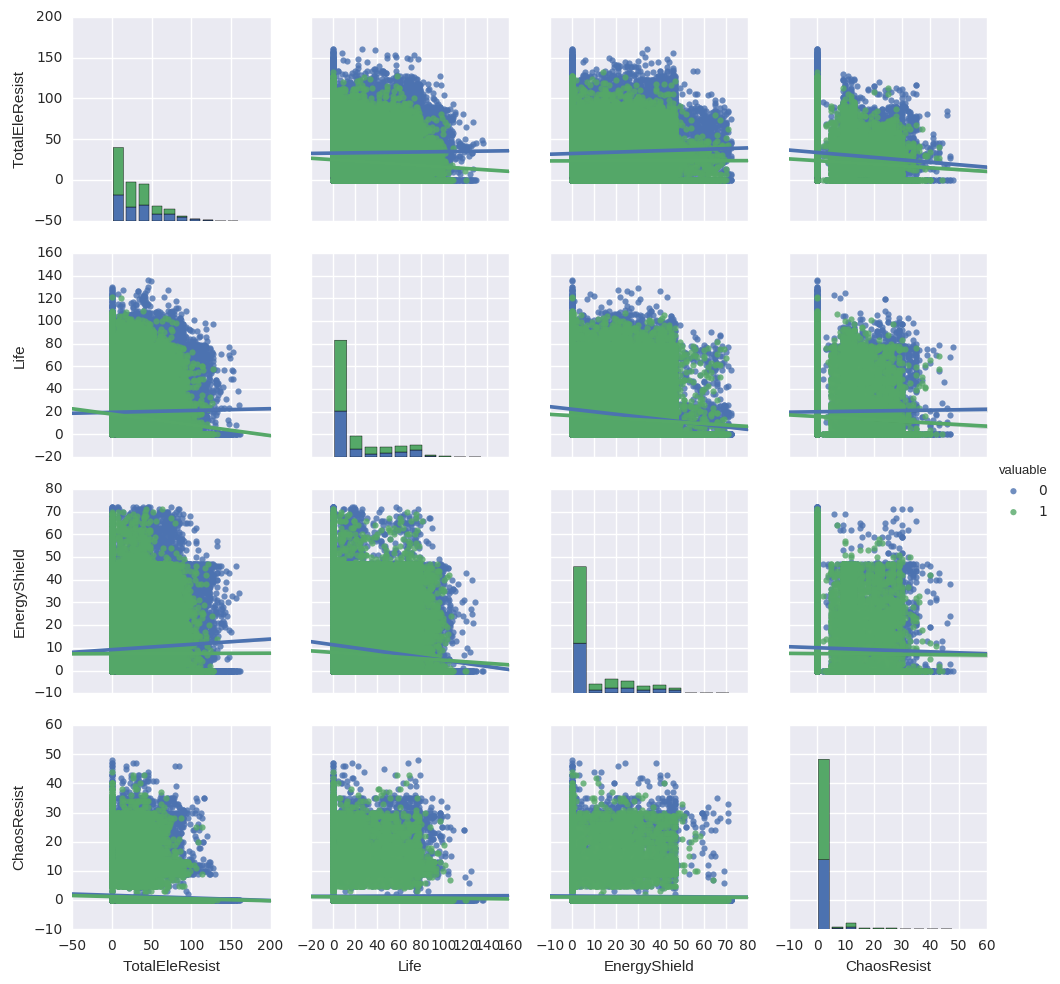

In [73]:
import seaborn as sns
sns.set()
sns_data = full_pd.copy()
sns_data['valuable'] = full_pd['valuable'].apply(lambda x: 1-x)
sns.pairplot(data=sns_data, hue='valuable', vars=['TotalEleResist','Life','EnergyShield','ChaosResist'])